# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Read the data first

In [4]:
from nb_utils import read_commits

# model files per repository and the elapsed days between the commit and safetensor's release date
df = read_commits()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']
df_safetensors

,repo_url,commit_hash,model_file_path,serialization_format,Unnamed: 4,Unnamed: 5,Unnamed: 6,date,message,elapsed_days
0,microsoft/resnet-50,34c2154c194f829b11125337b98c8f5f9965ff19,microsoft/resnet-50/model.safetensors,safetensors,NaN,NaN,NaN,2024-02-13 16:24:05,Adding `safetensors` variant of this model (#4...,508
3,microsoft/resnet-18,f45a6faa12e0381f5620c5c8d7e916bca90f2c44,microsoft/resnet-18/model.safetensors,safetensors,NaN,NaN,NaN,2023-05-08 07:19:40,Adding `safetensors` variant of this model (#2...,227
6,pritamdeka/BioBert-PubMed200kRCT,73ac04efdc8a89e33c98950dedb72a523a7627eb,pritamdeka/BioBert-PubMed200kRCT/model.safeten...,safetensors,NaN,NaN,NaN,2023-03-24 05:56:58,Adding `safetensors` variant of this model (#1...,182
24,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-12L-95M-i4096/model.s...,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
26,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-12L-95M-i4096_CLcance...,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
...,...,...,...,...,...,...,...,...,...,...
7119,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,EleutherAI/gpt-neox-20b/model-00044-of-00046.s...,safetensors,NaN,NaN,NaN,2023-02-07 01:46:15,Adding `safetensors` variant of this model (#1...,137
7120,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,EleutherAI/gpt-neox-20b/model-00045-of-00046.s...,safetensors,NaN,NaN,NaN,2023-02-07 01:46:15,Adding `safetensors` variant of this model (#1...,137
7121,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,EleutherAI/gpt-neox-20b/model-00046-of-00046.s...,safetensors,NaN,NaN,NaN,2023-02-07 01:46:15,Adding `safetensors` variant of this model (#1...,137
7171,bigscience/T0pp,7df7b1c1aa361dd74049d0b794a01801fb4563de,bigscience/T0pp/model.safetensors,safetensors,NaN,NaN,NaN,2024-03-19 12:02:07,Adding `safetensors` variant of this model (#1...,543


## Analysis 1: How many commits containing safetensors files were made by the SFconvertbot?

HuggingFace has a bot (https://huggingface.co/SFconvertbot) that converts models to safetensors.
How many commits were made by the bot and how many were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [5]:
from pathlib import Path

bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_bot = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_bot = df_safetensors[df_safetensors['message'].str.contains(bot_message)]

num_commits = len(df['commit_hash'].unique())
num_safetensors_commits = len(df_safetensors['commit_hash'].unique())
num_safetensors_commits_by_bot = len(df_safetensors_by_bot['commit_hash'].unique())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_bot['commit_hash'].unique())

print(f"# commits: {num_commits}")
print(f"# commits touching safetensor files: {num_safetensors_commits}")
print(f"% commits made by the bot: {num_safetensors_commits_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_by_bot})")
print(f"% commits made by developers: {num_safetensors_commits_not_by_bot / num_safetensors_commits * 100:.1f}% ({num_safetensors_commits_not_by_bot})")


df_safetensors_not_by_bot.to_csv(Path('../../results/safetensors_commits_not_by_bot.csv'), index=False)
df_safetensors_not_by_bot

# commits: 4095
# commits touching safetensor files: 436
% commits made by the bot: 85.1% (371)
% commits made by developers: 14.9% (65)


,repo_url,commit_hash,model_file_path,serialization_format,Unnamed: 4,Unnamed: 5,Unnamed: 6,date,message,elapsed_days
24,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-12L-95M-i4096/model.s...,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
26,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-12L-95M-i4096_CLcance...,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
28,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-20L-95M-i4096/model.s...,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
30,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/gf-6L-30M-i2048/model.sa...,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
33,ctheodoris/Geneformer,933ca80e39d421c47a12168699766bb7e4e2c197,ctheodoris/Geneformer/model.safetensors,safetensors,NaN,NaN,NaN,2024-08-15 04:09:57,"update with 12L and 20L i4096 gc95M models, mu...",692
...,...,...,...,...,...,...,...,...,...,...
5867,almanach/camembert-large,ca4958806381fbad174ad2cdfc1eeeb693d14b56,almanach/camembert-large/model.safetensors,safetensors,NaN,NaN,NaN,2024-07-21 12:51:38,Upload new model.safetensors with correct word...,667
6412,FacebookAI/roberta-large,5069d8a2a32a7df4c69ef9b56348be04152a2341,FacebookAI/roberta-large/model.safetensors,safetensors,NaN,NaN,NaN,2022-09-29 11:22:07,Convert weights to .safetensors (#1)\n\n\n- Co...,6
6420,FacebookAI/roberta-base,ff46155979338ff8063cdad90908b498ab91b181,FacebookAI/roberta-base/model.safetensors,safetensors,NaN,NaN,NaN,2022-09-29 11:21:48,Convert weights to .safetensors (#3)\n\n\n- Co...,6
6432,openai-community/gpt2,75e09b43581151bd1d9ef6700faa605df408979f,openai-community/gpt2/model.safetensors,safetensors,NaN,NaN,NaN,2022-10-20 05:34:54,Upload model.safetensors with huggingface_hub ...,27


## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

In [6]:
# find the lowest number of elapsed days per unique repo_url
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min()
df_safetensors_first_appearance = df_safetensors_first_appearance.reset_index()
min = df_safetensors_first_appearance['elapsed_days'].min()
max = df_safetensors_first_appearance['elapsed_days'].max()
median = df_safetensors_first_appearance['elapsed_days'].median()
quartile2 = df_safetensors_first_appearance['elapsed_days'].quantile(0.25)
quartile4 = df_safetensors_first_appearance['elapsed_days'].quantile(0.75)
# count number of repos without safetensors
print("Number of analyzed repos: ", len(df['repo_url'].unique()))
print(f"Number of repos without safetensors: {len(df['repo_url'].unique()) - len(df_safetensors_first_appearance)}")
print("Number of repos using safe tensors", len(df_safetensors_first_appearance))
print("min, quartile2, median, quartile4, max=",min, quartile2, median, quartile4, max)

Number of analyzed repos:  844
Number of repos without safetensors: 460
Number of repos using safe tensors 384
min, quartile2, median, quartile4, max= 6 227.75 520.5 551.0 733


## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

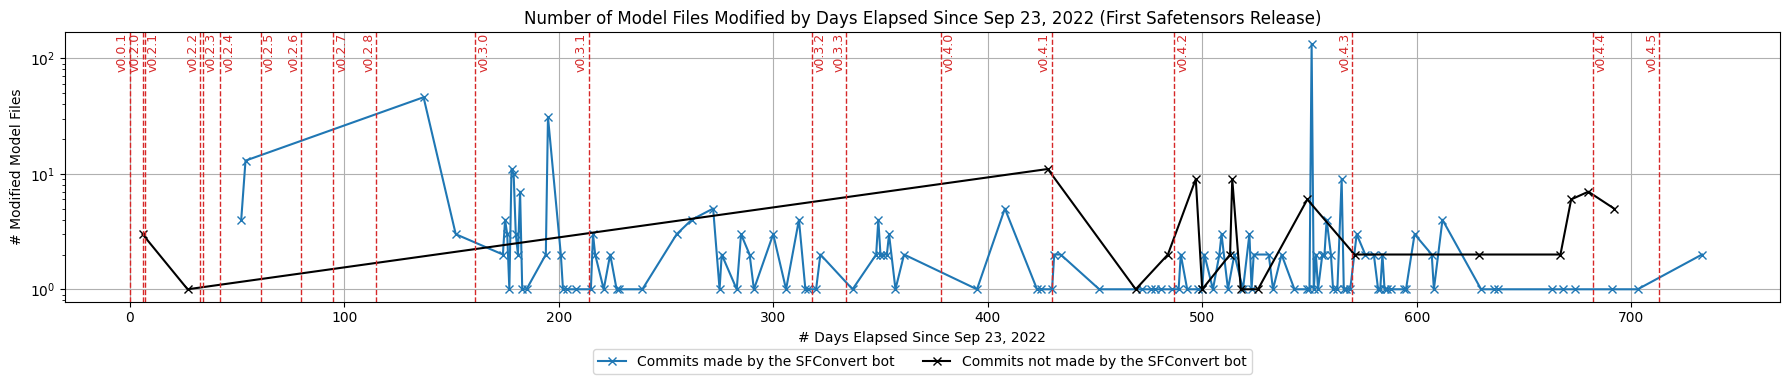

In [24]:
from pathlib import Path
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_bot['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_bot['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(18,4))
plt.plot(commits_by_bot.index, commits_by_bot.values, marker='x', linestyle='-', label="commits by bot")
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values, marker='x', linestyle='-',color='black',  label="commits not by bot")
plt.xlabel("# Days Elapsed Since Sep 23, 2022")
plt.ylabel("# Modified Model Files")
plt.title("Number of Model Files Modified by Days Elapsed Since Sep 23, 2022 (First Safetensors Release)")
plt.yscale('log')
plt.grid(True)



df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
i = 0
x_coordinates = [1, -6.5]
for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff,color='tab:red', linestyle='--', linewidth=1)
    x_offset = 1.5 if label == 'v0.2.4' else  x_coordinates[i]
    plt.text(diff + x_offset, plt.ylim()[1] * 0.99, label, color='tab:red', rotation=90, verticalalignment='top', fontdict={'size':9.0})
    if label == 'v0.0.1': i = 2
    

plt.legend(('Commits made by the SFConvert bot','Commits not made by the SFConvert bot'),loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
# Save the plot as a PDF file
plt.savefig(Path('../../results/RQ1SafetensorsAdoption.pdf'), format="pdf", bbox_inches="tight")

plt.show()

## Analysis 4: Analyze SFConvert bot's dataset

In [ ]:
from datasets import load_dataset
import requests
from tqdm import tqdm
ds = load_dataset("safetensors/conversions")['train']
# convert dataset to dataframe
df_sfconvert = ds.to_pandas()
df_sfconvert['time'].min(), df_sfconvert['time'].max()

# iterate over dataframe to check whether the PRs were merged
for i, row in tqdm(df_sfconvert.iterrows()):
    pr_url = row['pr_url']
    # make an HTTP request
    response = requests.get(pr_url)
    # check if the PR was merged
    if response.status_code == 200:
        html = response.text
        if 'Ready to merge' in html:
            df_sfconvert.loc[i, 'merged'] = "Ready to Merge"
        elif 'Cannot merge' in html:
            df_sfconvert.loc[i, 'merged'] = "Cannot merge"        
        # try to find the string changed pull request status to N, and extract status from it
        elif 'changed pull request status to' in html:
            status = html.split('changed pull request status to')[1].split('</strong>')[0].strip()        
            status = status.replace('<strong class="text-gray-700">', '')
            df_sfconvert.loc[i, 'merged'] = status
    else:
        df_sfconvert.loc[i, 'merged'] = "HTTP Error (status code = {response.status_code})"
    # SAVES THE DATAFRAME EVERY 500 ITERATIONS
    if i!= 0 and i % 500 == 0:
        df_sfconvert.to_csv(Path(f'../../results/sfconvertbot_merge_status_{i}.csv'), index=False)
    # print(f"{pr_url} {df_sfconvert.loc[i, 'merged']}")


    

2865it [13:55,  2.73it/s]